In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, CSVLogger
from CinemaNet.train_utils import *
from CinemaNet.wandb import *
from CinemaNet.MixMatch import *
from CinemaNet.data_3000L import *
from CinemaNet.custom_head import *

import wandb

In [3]:
model_name = 'FBNet_C-150x266-3000L'

In [4]:
re.sub('-\d+L', '', model_name)

'FBNet_C-150x266'

In [5]:
#hide
wandb.init(name=re.sub('-\d+L', '', model_name),
           project='Shot Framing -- Supervised (3000L)',
           tags=['MobileNetV3'],
           entity='synopsis')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


W&B Run: https://app.wandb.ai/synopsis/Shot+Framing+--+Supervised+%283000L%29/runs/qisedy8f

In [6]:
#hide
%env WANDB_NOTEBOOK_NAME='08-1-FBNet_C-150x266-3000L.ipynb'

env: WANDB_NOTEBOOK_NAME='08-1-FBNet_C-150x266-3000L.ipynb'


## Setup

### Dataset

Data grabbing functions in `CinemaNet/data_3000L.py`

In [7]:
img_size   = to_film_ar(150)
img_size

(150, 266)

In [8]:
data = get_data_3000L(img_size)
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Extreme Close-Up,Extreme Close-Up,Extreme Wide,Extreme Close-Up,Extreme Wide
Path: .;

Test: None

6

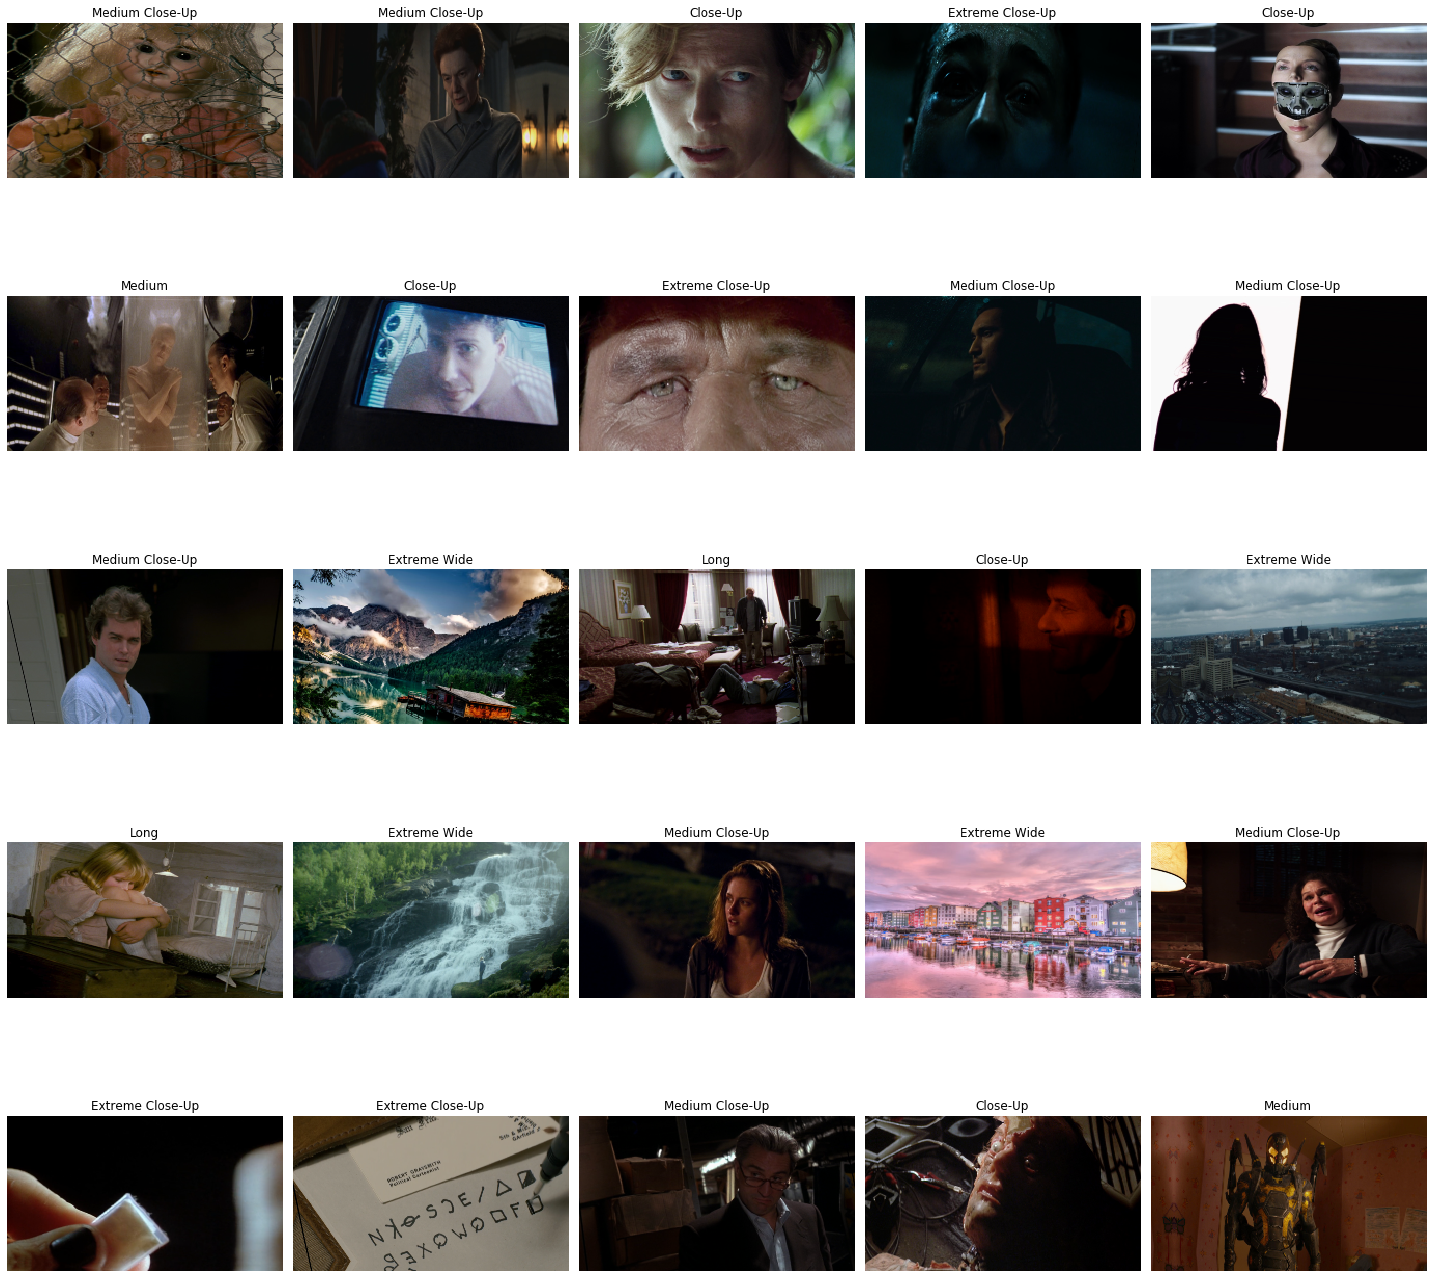

In [9]:
data.c
data.show_batch()

## Training (150, 266)

### Frozen -- Head Only

In [11]:
from geffnet.gen_efficientnet import fbnetc_100

In [19]:
fbnet_spit = lambda m: (m[0][3][3][3], m[1])
arch = fbnetc_100
learn = cnn_learner(data, arch, pretrained=True, metrics=metrics,
                    cut=None, split_on=fbnet_spit)

[len(grp) for grp in learn.layer_groups]

[102, 93, 10]

In [20]:
learn.model.train();

In [21]:
learn.data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Close-Up,Close-Up,Close-Up,Close-Up,Close-Up
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266),Image (3, 150, 266)
y: CategoryList
Extreme Close-Up,Extreme Close-Up,Extreme Wide,Extreme Close-Up,Extreme Wide
Path: .;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


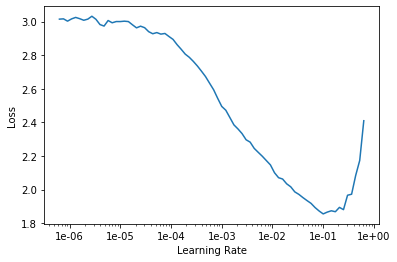

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
def get_callbacks(learner, mod_name, early_stop=True, patience=5, monitor='accuracy', min_delta=0.01):
    callbacks=[
        SaveModelCallback(learner, every='improvement', name=f'{mod_name}', monitor=monitor),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images', log='all')
    ]
    if early_stop: callbacks.append(EarlyStoppingCallback(learner, patience=patience, min_delta=min_delta, monitor=monitor))
    return callbacks

In [24]:
model_name

'FBNet_C-150x266-3000L'

In [25]:
callbacks = get_callbacks(learn, model_name, early_stop=False)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.413661,0.974106,0.698873,0.724493,0.747703,00:45
1,0.974417,0.735720,0.758454,0.768191,0.791857,00:43
2,0.750427,0.595729,0.792593,0.803669,0.810688,00:44
3,0.572502,0.517721,0.816425,0.817798,0.838081,00:44
4,0.445431,0.483095,0.834783,0.837971,0.851550,00:47
5,0.337390,0.559521,0.814171,0.826127,0.848524,00:45
6,0.254729,0.483464,0.833816,0.838848,0.860030,00:44
7,0.207964,0.452111,0.838969,0.844349,0.855341,00:44
8,0.173886,0.460916,0.840580,0.841359,0.861692,00:45


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.6988728046417236.
Better model found at epoch 0 with accuracy value: 0.6988728046417236.
Better model found at epoch 1 with accuracy value: 0.7584540843963623.
Better model found at epoch 1 with accuracy value: 0.7584540843963623.
Better model found at epoch 2 with accuracy value: 0.7925925850868225.
Better model found at epoch 2 with accuracy value: 0.7925925850868225.
Better model found at epoch 3 with accuracy value: 0.8164251446723938.
Better model found at epoch 3 with accuracy value: 0.8164251446723938.
Better model found at epoch 4 with accuracy value: 0.834782600402832.
Better model found at epoch 4 with accuracy value: 0.834782600402832.
Better model found at epoch 7 with accuracy value: 0.8389694094657898.
Better model found at epoch 7 with accuracy value: 0.8389694094657898.
Better model found at epoch 8 with accuracy value: 0.8405796885490417.
Better model found at epoch 8 with accuracy value: 0.8405796885490417.
Loaded b

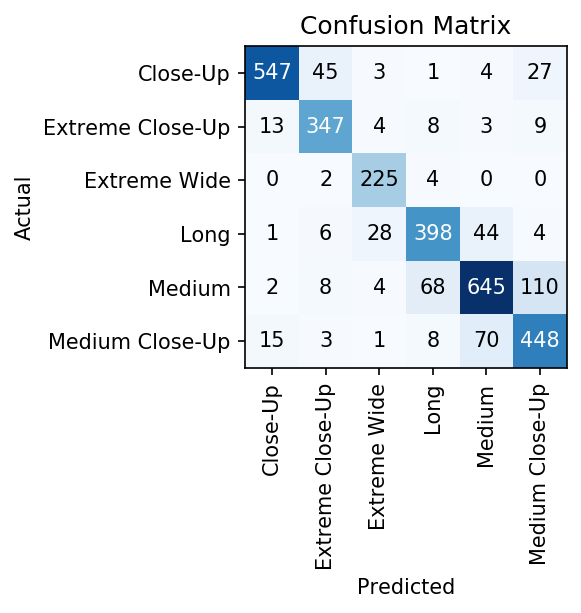

In [26]:
learn.fit_one_cycle(9, 5e-3, callbacks=callbacks)

### Unfrozen

In [27]:
model_name

'FBNet_C-150x266-3000L'

In [28]:
learn.unfreeze()
model_name = f'{model_name}-unfrozen'
callbacks = get_callbacks(learn, model_name)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


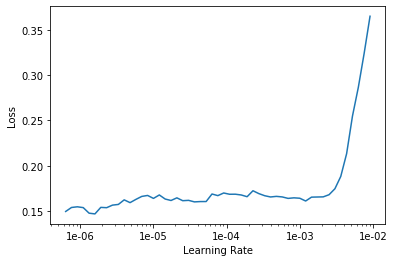

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
callbacks = get_callbacks(learn, model_name, early_stop=False)


epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.187073,0.446295,0.841546,0.844852,0.859408,00:45
1,0.164102,0.461893,0.839291,0.841906,0.860558,00:41
2,0.145530,0.460107,0.839291,0.840873,0.861707,00:41
3,0.142761,0.465262,0.839936,0.840501,0.861271,00:41
4,0.130411,0.454852,0.842512,0.844755,0.858425,00:45
5,0.138160,0.467311,0.845089,0.848193,0.863130,00:43
6,0.132823,0.494448,0.842834,0.845677,0.862981,00:43
7,0.128160,0.495299,0.847343,0.851223,0.865935,00:45
8,0.108349,0.482826,0.842834,0.847960,0.859625,00:46
9,0.107312,0.513958,0.841868,0.848554,0.857218,00:44


Better model found at epoch 0 with accuracy value: 0.8415458798408508.
Better model found at epoch 0 with accuracy value: 0.8415458798408508.


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


Better model found at epoch 4 with accuracy value: 0.8425120711326599.
Better model found at epoch 4 with accuracy value: 0.8425120711326599.
Better model found at epoch 5 with accuracy value: 0.845088541507721.
Better model found at epoch 5 with accuracy value: 0.845088541507721.
Better model found at epoch 7 with accuracy value: 0.8473429679870605.
Better model found at epoch 7 with accuracy value: 0.8473429679870605.
Better model found at epoch 10 with accuracy value: 0.8483091592788696.
Better model found at epoch 10 with accuracy value: 0.8483091592788696.
Better model found at epoch 11 with accuracy value: 0.8495973944664001.
Better model found at epoch 11 with accuracy value: 0.8495973944664001.
Better model found at epoch 14 with accuracy value: 0.853140115737915.
Better model found at epoch 14 with accuracy value: 0.853140115737915.
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200122_055850-qisedy8f/bestmodel.pth


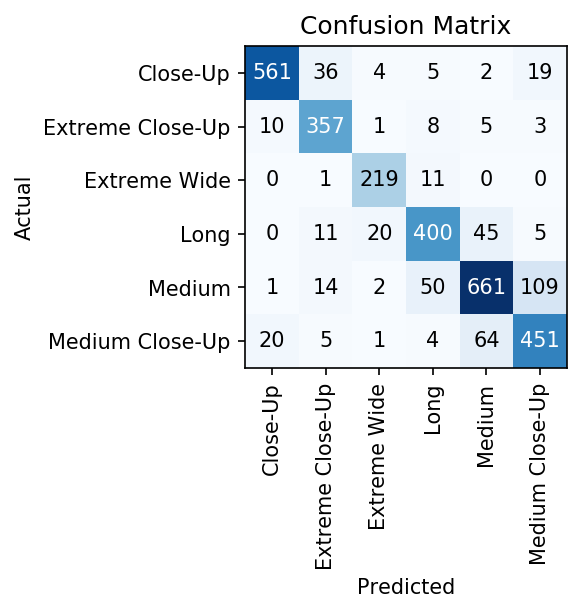

In [31]:
learn.fit_one_cycle(25, slice(1e-6, 1e-3), callbacks=callbacks)


In [32]:
config = wandb.config

config.img_size = img_size
config.batch_size = learn.data.batch_size
config.len_train = len(learn.data.train_ds)
config.len_valid = len(learn.data.valid_ds)
config.model = re.sub('-unfrozen', '', model_name)


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


### Export to CoreML

In [33]:
from CinemaNet.convert import *
from CinemaNet.custom_head import *

In [34]:
model_name

'FBNet_C-150x266-3000L-unfrozen'

In [35]:
learn = cnn_learner(data, arch, pretrained=True, metrics=metrics,
                    cut=-1, split_on=mobilenet_split)
learn.load(f'{model_name}');


In [36]:
model_fname=re.sub('-unfrozen.*', '', model_name)
model_fname

'FBNet_C-150x266-3000L'

In [37]:
torch_to_coreml(learn.model, data.c,
                model_fname=model_fname,
                img_size=img_size)

1/203: Converting Node Type Conv
2/203: Converting Node Type BatchNormalization
3/203: Converting Node Type Relu
4/203: Converting Node Type Conv
5/203: Converting Node Type BatchNormalization
6/203: Converting Node Type Relu
7/203: Converting Node Type Conv
8/203: Converting Node Type BatchNormalization
9/203: Converting Node Type Relu
10/203: Converting Node Type Conv
11/203: Converting Node Type BatchNormalization
12/203: Converting Node Type Add
13/203: Converting Node Type Conv
14/203: Converting Node Type BatchNormalization
15/203: Converting Node Type Relu
16/203: Converting Node Type Conv
17/203: Converting Node Type BatchNormalization
18/203: Converting Node Type Relu
19/203: Converting Node Type Conv
20/203: Converting Node Type BatchNormalization
21/203: Converting Node Type Conv
22/203: Converting Node Type BatchNormalization
23/203: Converting Node Type Relu
24/203: Converting Node Type Conv
25/203: Converting Node Type BatchNormalization
26/203: Converting Node Type Relu


In [38]:
!ls -l ../{model_fname}*

-rw-rw-r-- 1 rahul rahul  536 Jan 22 11:40 ../FBNet_C-150x266-3000L-history.csv
-rw-rw-r-- 1 rahul rahul 1399 Jan 22 12:05 ../FBNet_C-150x266-3000L-unfrozen-history.csv


In [39]:
!ls -l ../exported-models/{model_fname}*

-rw-rw-r-- 1 rahul rahul 22749102 Jan 22 12:08 ../exported-models/FBNet_C-150x266-3000L.mlmodel
-rw-rw-r-- 1 rahul rahul 22761002 Jan 22 12:08 ../exported-models/FBNet_C-150x266-3000L.onnx


In [40]:
wandb.save(f'../exported-models/{model_fname}*')
wandb.save(f'../{model_fname}*')


Error generating diff: Command '['git', 'diff', '--submodule=diff', '747359307a168f411ffb9fcfe9d768f1d7920bfd']' timed out after 5 seconds


['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200122_055850-qisedy8f/FBNet_C-150x266-3000L.mlmodel',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200122_055850-qisedy8f/FBNet_C-150x266-3000L.onnx']

['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200122_055850-qisedy8f/FBNet_C-150x266-3000L-history.csv',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200122_055850-qisedy8f/FBNet_C-150x266-3000L-unfrozen-history.csv']